<center><br><br><b><font size=10> NAVIGATION </font></b><br><br>
<font size = 4><i>...implementation for Udacity Deep Reinforcement Learning 
<hr>

##### Load a few extensions before doing anything else...

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [38]:
from notebook_utils import *
from IPython.display import HTML
from IPython.display import YouTubeVideo

# Project Overview, Results, & To-Do

### Agent overview

This codebase implements a **Deep Q-Learning (DQN)** agent based upon the groundbreaking work by Google DeepMind, found here:  
https://arxiv.org/abs/1312.5602

Additionally, and as the default behavior (and all of the above graphed results), **Double Deep Q-Learning (DDQN)** is implemented. DDQN provides more stable and faster learning than the original algorithm.  
https://arxiv.org/abs/1509.06461

The basic algorithm uses a Neural Network to approximate the Action-Value function (Q) and generate an optimal policy by maximizing the returns. DeepMind's breakthrough was to use Experience Replay, by storing previous experiences for future learning, and off-policy networks to stabilize learning, which had previously been unstable when learning on-policy with neural networks. 

**DQN** learns by minimizing the error as computed by the value predictions between an online learning policy, and a delayed copy called a Target Network, which is updated only irregularly. Values are computed using the Bellman equation.

**DDQN**'s continuation of this concept is to stabilize action-value estimation by estimating the value of the target network using the maximizing action under the active/local network. 

*Lastly, this agent uses N-Step Bootstrapping as adapted from later project agents. N-Step bootstrapping performs Temporal-Difference (TD) Learning across N steps instead of a single SARS' tuple. N-Step bootstrapping is not required, nor especially beneficial to this environment and will be left to other projects for a more full description.*


### Because who doesn't like to see the results before the details...

Notice that the first two graphs use the same hyperparameters and both achieve much better than goal-score performance, but there is a wide variance in performance between runs.

Also, in the fourth example, that with tuning, the DDQN agent can solve this environment in <200 episodes!

**To see this agent in action, run the following command:**  
`python main.py -eval`  
*or if you wish to see more than two episodes of evaluation, try this:*  
`python main.py --force_eval -num 5`  

You will be prompted to load a file on the command line, and as long as the provided weights are somewhere in tree below your current directory, the file should be found!

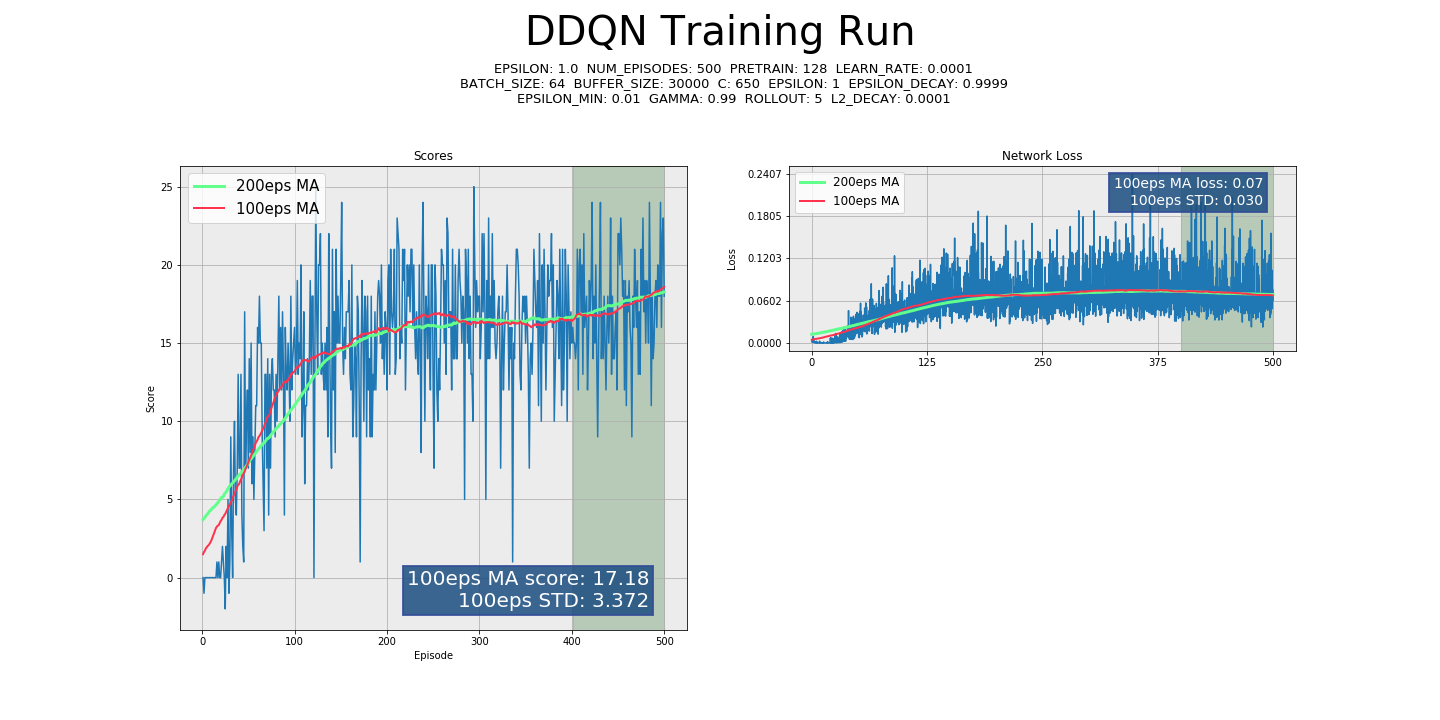
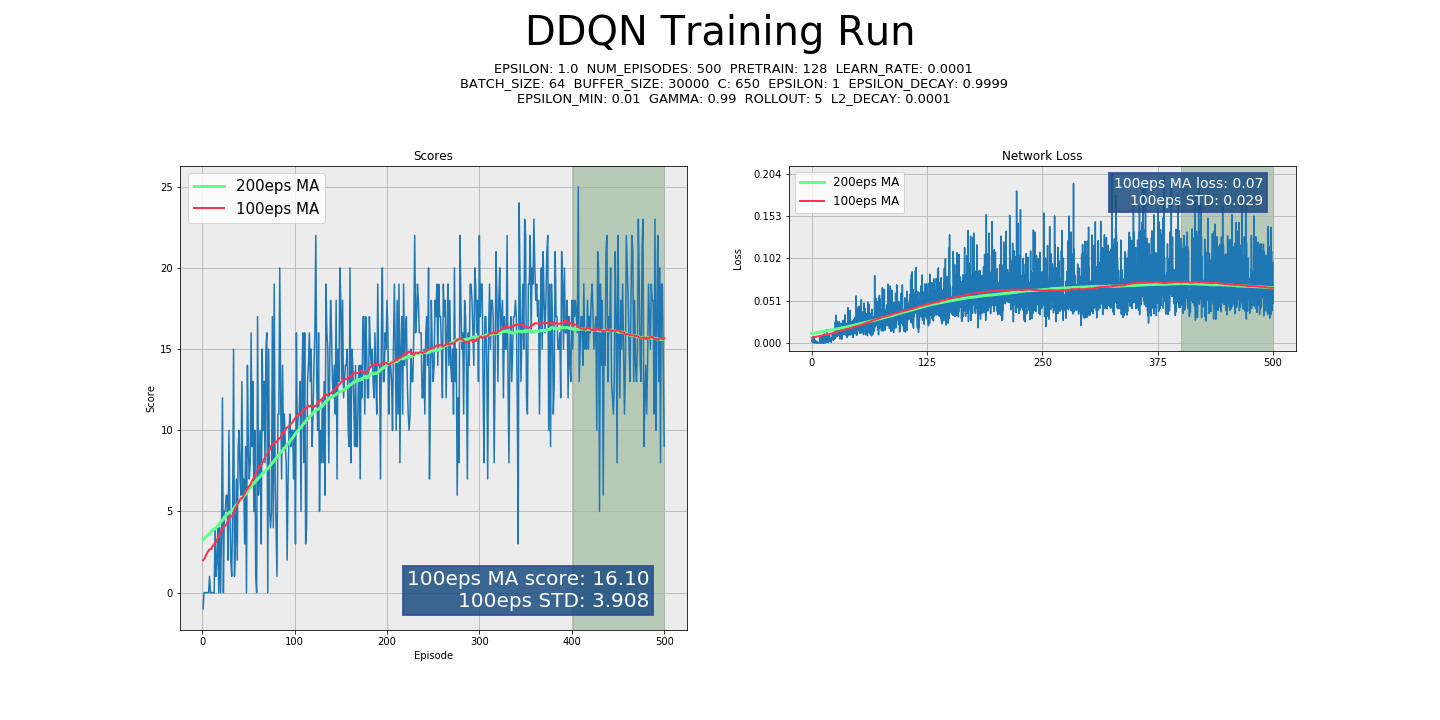
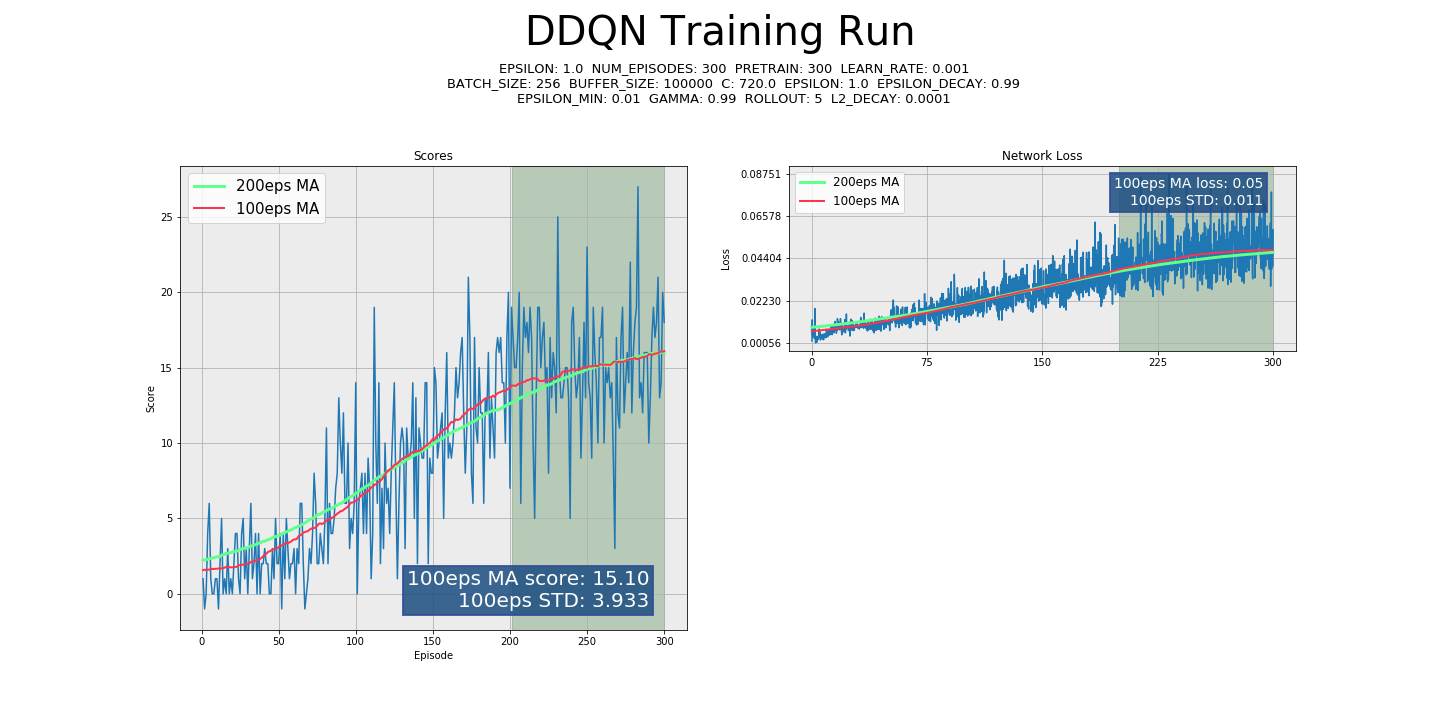
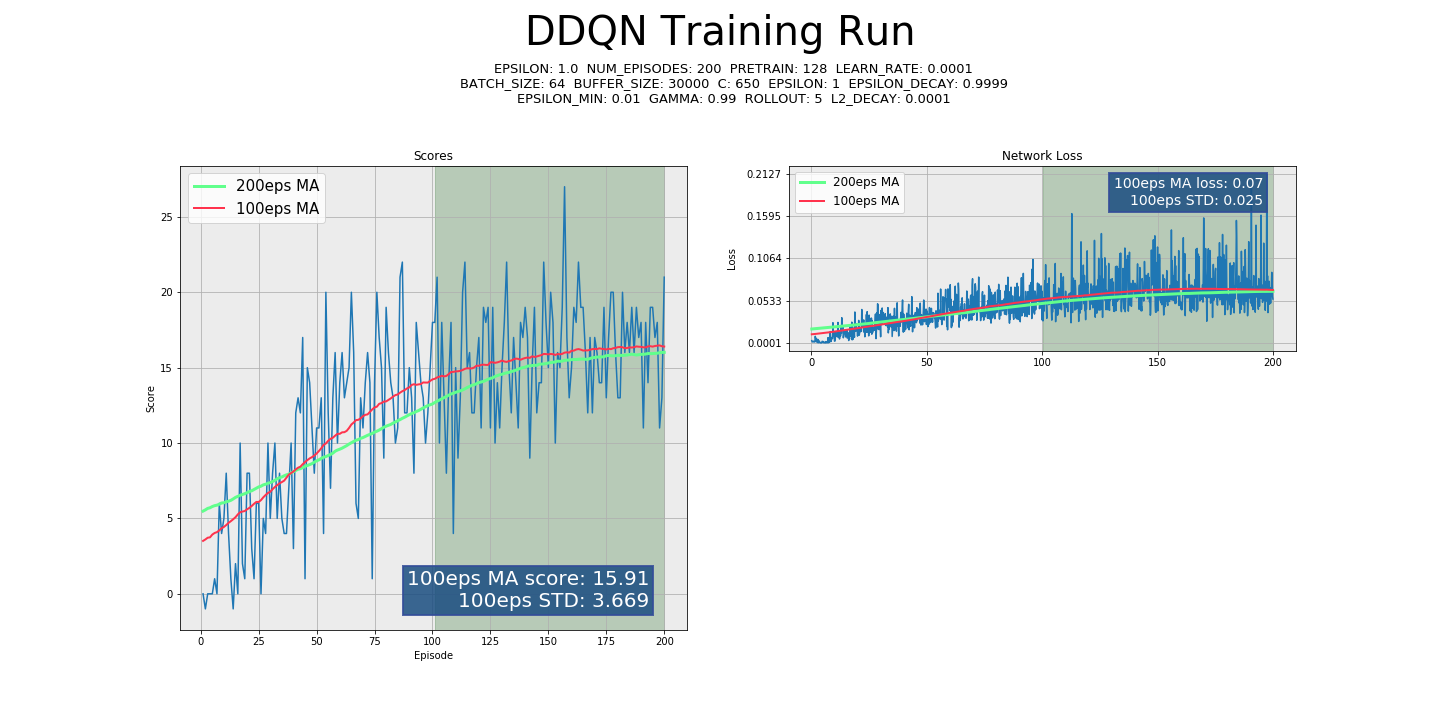

### Hyper Parameters

**DDQN** has proven robust to a fairly wide variety of hyperparameters. 
* `LEARN_RATE` The above graphs show an order of magnitude variance in Learning Rate while still converging to optimal performance.
* `C/TAU` I have consistently, across all projects, found that a HARD update type utilizing a parameter C controlling how many timesteps between updates, gives me superior performance over soft-update style gradual target network updating using parameter TAU. In the above graphs, C is consistently set to 650, though 720 is used in  the third. The relationship between training and updates seems to remain somewhat ambiguous, however, for this project, ensuring that some small multiple of episodes passes before updating the network provided good results. As this Banana environment performed 300 timesteps before reaching a Done state, 650-750 was a good range of allowing for learning before updating the networks.
* `EPSILON` Annealing Epsilon at a slow rate was key to stable and fast learning as well, allowing a balance between exploration and exploitation. In this project, Epsilon annealing is has no relationship with actual Agent performance, and in later code this is no longer the case. Epsilon annealing rate should have some relationship with Agent performance for the most consistent results without requiring hand tuning. However, this requires some knowledge of the environment about *what constitutes a good score or good performance.*
* `PRETRAIN` Interestingly, it was found that filling the ReplayBuffer with many more memories than required to sample a batch led to significantly worse performance or non-convergence. This is counterinuitive and in fact the opposite of findings from other projects, and should be further studied. Regardless, for Banana, pretrain was best left at a low number.
* `ROLLOUT` As stated above, n-step rollout was allowed to run in this environment, but was inconsequential to the results. This parameter could be set to 1 and achieve the same scores. Theoretically, having a rollout contribution should stabilize learning, but there was not computing bandwidth to run trials of this.
* `L2_DECAY` Adding a very small Adam Optimizer l2 decay seemed to be a benefit, this parameter was never tuned in a meaningful way.

### Future Ideas

* This was my first Reinforcement Learning project and as such some of the code is not as pretty as it could/should be, or as flexible, and I would like to circle back to implement DQN/DDQN into the more mature code structure of the later projects
* **Prioritized Experience Replay (PER)** (https://arxiv.org/abs/1511.05952) was implemented, but never fully tested. I would like to optimize and adapt this more generally for future agents of all frameworks. Although this class did not require PER to achieve fast, excellent results on any projects, this would be a great tool to add into any Reinforcement Learning framework.
* **Dueling DQN** would be good to explore further. While I became familiar with the concepts of an Advantage function (which is the key contribution of Dueling DQN to the overall algorithm) during study, I have yet to implement an agent with an Advantage function portion. This is key to many policy based algorithms and is a high priority for further study.
* A so-called **"Rainbow"** implementation would utilize all of these tools to produce a superior agent.
* **Visual/Pixel based training** was implemented but was not successful, in this project, at converging in any predictable way. Due to time constraints I moved on to other projects and more advanced/state-of-the-art algorithms, but training from visual data is extremely important to machine learning in general and I need to devote further time to a strong implementation of convolutional neural network based training.

## Click below to watch the trained Agent!
[!["Train Agent"](http://img.youtube.com/vi/4bjDPNpwya0/0.jpg)](https://www.youtube.com/watch?v=4bjDPNpwya0 "Banana Collector")

# Implementation Details

## Initialize Imports
This Notebook uses code from separate python files where most of the implementation is handled

In [4]:
import numpy as np
from agent import DQN_Agent
from environment import Environment
from data_handling import Logger, Saver, gather_args

## Implement `MENU.PY`
#### <i> This implementation was originally intended to be run on the command-line, so we'll need to import the functions from main.py and explore.

### Simulate a command line `Args`
Commandline arguments run the entire show, we'll have to simulate a command line entry.

In [5]:
cmd_args = "--num_episodes 500 --learn_rate 0.0001 --batch_size 64 -C 650"

In [6]:
args = gather_args(cmd_args.split())

Let's check out what arguments have been loaded...

In [7]:
print_args(args)

framework: DDQN
learn_rate: 0.0001
alpha: 0.6
beta: 0.4
batch_size: 64
buffer_size: 100000
eval: False
force_eval: False
gamma: 0.99
epsilon: 1.0
epsilon_decay: 0.9999
epsilon_min: 0.01
framestack: 4
frameskip: 4
momentum: 0.99
nographics: False
num_episodes: 500
max_steps: 1000
optimizer: Adam
pixels: False
pretrain: 128
prioritized_experience_replay: False
quiet: False
resume: False
rollout: 5
save_every: 50
C: 650
tau: 0.0005
latest: False
filename: None
save_dir: saves
device: cuda:0
load_file: False


### Set up the `Environment`
Now that args are loaded, we can load the environment.

In [8]:
env = Environment(args)

LOADING ON SYSTEM: Windows
##################################################
#                                                #


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


#                                                #
##################################################


Print some information about the environment.

In [9]:
print("Num Agents:", env.agent_count)
print("Action size:", env.action_size)
print("State size:", env.state_size)

Num Agents: 1
Action size: 4
State size: 37


#### Take random actions in the Environment
* Check that the environment is working
* Test commands and see the results!

While testing out the environment, set training mode to False, and limit max_steps to ensure it doesn't run too long for testing purposes.

In [10]:
env.train = False
env.reset()
num_eps = 1
state = env.state
for _ in range(50):
    score = np.zeros(env.agent_count)
    env.reset()
    actions = np.random.randint(env.agent_count, env.action_size)
    next_state, reward, done = env.step(actions)
    state = next_state

In [11]:
print_env_info(state, actions, reward)

The agent chooses ACTIONS that look like:
3

The environment returns STATES that look like:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.2690, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0289, 0.0000, 1.0000, 0.0000, 0.0000, 0.2410, 1.0000, 0.0000, 0.0000,
         0.0000, 0.7052, 1.0000, 0.0000, 0.0000, 0.0000, 0.0490, 1.0000, 0.0000,
         0.0000, 0.0000, 0.6333, 1.0000, 0.0000, 0.0000, 0.0000, 0.0302, 0.0000,
         0.0000]])

The environment returns REWARDS that look like:
0.0


### Load the `Agent` and `Saver` objects
* The DQN_Agent object will use the framework specified in the commandline arguments
* The Saver object will select a savename based on the framework, current time, and version-up if necessary. No files or folders are created until there is a file to write.

In [22]:
# Using the params from args and the environment, set up an agent for training
agent = DQN_Agent(env.state_size, env.action_size, args)

# The Saver object will do all the saving and loading for the Agent
saver = Saver(agent.framework, agent, args.save_dir, args.load_file)

##################################################
#                                                #
   Saving to base filename: DDQN_20190402_v003    
#                                                #
##################################################


## Training
Now that the initial setup is created, training is as simple as running the `train()` routine. We'll take a look inside each step below.

For Notebook purposes, saving has been disabled. Closing the environment is also disabled because the environment errors if closed and reopened in the Notebook.

In [23]:
def train(agent, args, env, saver):
    """
    Train the agent.
    """

    logger = Logger(agent, args, saver.save_dir, log_every=50)

    # Pre-fill the Replay Buffer
    agent.initialize_memory(args.pretrain, env)

    #Begin training loop
    for episode in range(1, args.num_episodes+1):
        # Begin each episode with a clean environment
        done = False
        env.reset()
        # Get initial state
        state = env.state
        # Gather experience until done or max_steps is reached
        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            if done:
                next_state = None
            agent.step(state, action, reward, next_state)
            state = next_state

            logger.log(reward, agent)


        #saver.save_checkpoint(agent, args.save_every)
        agent.new_episode()
        logger.step(episode, agent.epsilon)

    #env.close()
    #saver.save_final(agent)
    logger.graph(save_to_disk=False)
    return 

### *Reviewing each step*

#### Create `Logger` object
`logger = Logger(agent, args, saver.save_dir, log_every=50, print_every=5)`


* Logger:
    * prints status updates
    * keeps track of rewards
    * writes log files to disk
    * creates a graph for review at the end of training
    
#### Initialize memory
`agent.initialize_memory(args.pretrain, env)`

* Learning cannot begin until the ReplayBuffer has at least as many memories as batch_size
* In many cases, training is improved by collecting many random memories before learning from any given experience  
    * *`args.pretrain`* will fill the memory with however many random experience tuples as desired, usually in the thousands, although it was found during training that sometimes, setting this too high, reduces or eliminates convergence!
    
#### Training loop

```python
#Begin training loop
for episode in range(1, args.num_episodes+1):
    # Begin each episode with a clean environment
    done = False
    env.reset()
    # Get initial state
    state = env.state
    # Gather experience until done or max_steps is reached
    while not done:
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        if done:
            next_state = None
        agent.step(state, action, reward, next_state)
        state = next_state

        logger.log(reward, agent)
```

* Training will proceed for a specified number of episodes, in this code there is no implementation of early termination upon goal achievement.
* Perform a standard Reinforcement Agent training loop:
    * Get the initial state
    * Select an action
    * Collect next state, reward, and done-status from the environment after taking a step with the selected action
    * Store the experience tuple of S, A, R, S'
    * Rinse, wash, repeat
* Inside of *`agent.step`*, the current experience is stored as a memory, and learning is then performed. This will be reviewed later in the AGENT review section.
* Log the rewards for the current timestep

#### Post Episode

`saver.save_checkpoint(agent, args.save_every)`  
At the end of each episode, the agent saves checkpoint weights every so often, as defined by the commandline arguments.

`agent.new_episode()`  
The agent then resets.

`logger.step(episode, agent.epsilon)`  
Logger keeps track of the scores and anneals the epsilon. *Annealing Epsilon through the Logger object is not ideal, and in later project code, this is more appropriately handled in the Agent itself*

#### Post Training

`env.close()`
Close the environment.

 `saver.save_final(agent)`
Save a final weights file.

 `logger.graph()`
 Create a graph from the Log data created during training.

### What a training loop looks like in practice

In [25]:
#To run a quick test, limit the length of training
args.num_episodes = 15
args.print_every = 3
env.train = True

##################################################
#                                                #
          Starting training at: 11:13:32          
#                                                #
##################################################
##################################################
#                                                #
                    ALPHA: 0.6                    
                    BETA: 0.4                     
                FORCE_EVAL: False                 
                   EPSILON: 1.0                   
                  FRAMESTACK: 4                   
                   FRAMESKIP: 4                   
                NOGRAPHICS: False                 
                 NUM_EPISODES: 15                 
                 MAX_STEPS: 1000                  
                 OPTIMIZER: Adam                  
                  PIXELS: False                   
                  PRETRAIN: 128                   
       PRIORITIZED_EXPERIENCE_R

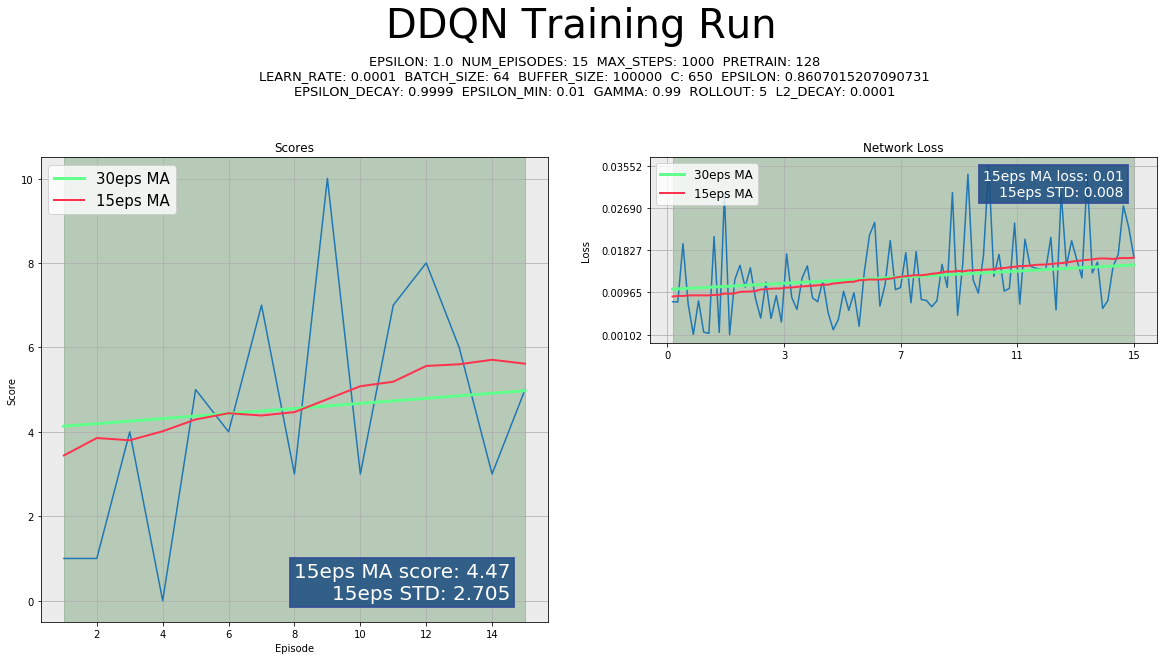

In [26]:
train(agent, args, env, saver)

In [28]:
# Close the environment
env.close()

ERROR:root:Exception calling application: 
Traceback (most recent call last):
  File "C:\Users\mattdoll\Anaconda3\envs\drlnd\lib\multiprocessing\connection.py", line 312, in _recv_bytes
    nread, err = ov.GetOverlappedResult(True)
BrokenPipeError: [WinError 109] The pipe has been ended

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\mattdoll\Anaconda3\envs\drlnd\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "C:\Users\mattdoll\Anaconda3\envs\drlnd\lib\site-packages\unityagents\rpc_communicator.py", line 26, in Exchange
    return self.child_conn.recv()
  File "C:\Users\mattdoll\Anaconda3\envs\drlnd\lib\multiprocessing\connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "C:\Users\mattdoll\Anaconda3\envs\drlnd\lib\multiprocessing\connection.py", line 321, in _recv_bytes
    raise EOFError
EOFError


## The Model

Before getting into the Agent, let's quickly review the Neural Network model, which is quite straightforward.

```python
class QNetwork(nn.Module):
    """
    Deep Q-Network Model. Nonlinear estimator for Qπ
    """

    def __init__(self, state_size, action_size, seed, layer_sizes=[64, 64]):
        """
        Initialize parameters and build model.
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.hidden_layers = nn.ModuleList([nn.Linear(state_size, layer_sizes[0])])
        self.output = nn.Linear(layer_sizes[-1], action_size)

        layer_sizes = zip(layer_sizes[:-1], layer_sizes[1:])
        self.hidden_layers.extend([nn.Linear(i, o) for i, o in layer_sizes])


    def forward(self, state):
        """
        Build a network that maps state -> action values.
        """

        x = F.relu(self.hidden_layers[0](state))
        for layer in self.hidden_layers[1:]:
            x = F.relu(layer(x))
        return self.output(x)
```

The network for estimating the Q-value takes in a state of `state_size` and outputs an estimate of size `action_size` which contains the estimated values of each action. For the Banana Collector environment this is a tensor of shape **\[batchsize, 37]** and **\[batchsize, 4]** respectively.

The network can accomodate an abritrary number of hidden layers as specified by the user, however, for this environment there is no benefit to an overly large network and a default value of 64x64 is sufficient.

The hidden layers use a ReLU activation function and simply output the final fully connected Linear Layer. Because we are outputting values and not probabilities, there is no activation function applied to the output.

## The Agent

### The Agent module is reviewed bit by bit.

#### Class
Initialize a Class to contain all of the Agent information and set up hyperparamaters.

```python
class DQN_Agent:
    """
    PyTorch Implementation of DQN/DDQN.
    """
    def __init__(self, state_size, action_size, args):
        """
        Initialize a D4PG Agent.
        """

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.action_size = action_size
        self.state_size = state_size
        self.framework = args.framework
        self.eval = args.eval
        self.agent_count = 1
        self.learn_rate = args.learn_rate
        self.batch_size = args.batch_size
        self.buffer_size = args.buffer_size
        self.C = args.C
        self._epsilon = args.epsilon
        self.epsilon_decay = args.epsilon_decay
        self.epsilon_min = args.epsilon_min
        self.gamma = 0.99
        self.rollout = args.rollout
        self.tau = args.tau
        self.momentum = 1
        self.l2_decay = 0.0001
        self.update_type = "hard"
        self.t_step = 0
        self.episode = 0
        self.seed = 0
```

#### Networks
Create the Experience Replay buffer of a chosen type, and initialize active and target networks. Copy the parameters from the active network to target network.


```python        
        # Set up memory buffers
        if args.prioritized_experience_replay:
            self.memory = PERBuffer(args.buffersize, 
                                    self.batchsize, 
                                    self.framestack, 
                                    self.device, 
                                    args.alpha, 
                                    args.beta)
            self.criterion = WeightedLoss()
        else:
            self.memory = ReplayBuffer(self.device, 
                                       self.buffer_size, 
                                       self.gamma, 
                                       self.rollout)

        #                    Initialize Q networks                         #
        self.q = self._make_model(state_size, action_size, args.pixels)
        self.q_target = self._make_model(state_size, action_size, args.pixels)
        self._hard_update(self.q, self.q_target)
        self.q_optimizer = self._set_optimizer(self.q.parameters(), 
                                               lr=self.learn_rate, 
                                               decay=self.l2_decay, 
                                               momentum=self.momentum)
        self.new_episode()
```


### `act()`
With probability of `epsilon`, the agent chooses a random action for encourage exploration. If not choosing a random exploratory action, then the agent calculates the current Q-value for the provided state, and chooses the maximizing action for the next timestep.

```python
    def act(self, state, eval=False, pretrain=False):
        """
        Select an action using epsilon-greedy π.
        Always use greedy if not training.
        """

        if np.random.random() > self.epsilon or not eval and not pretrain:
            state = state.to(self.device)
            with torch.no_grad():
                action_values = self.q(state).detach().cpu()
            action = action_values.argmax(dim=1).unsqueeze(0).numpy()
        else:
            action = np.random.randint(self.action_size, size=(1,1))
        return action.astype(np.long)
```

### `step()`
After collecting an experience tuple from the environment, the Agent stores the experience in the Replay Buffer. Memory storing happens at each timestep, and after enough experiences have been collected, then perform a `learn()` step.

```python
    def step(self, state, action, reward, next_state, pretrain=False):
        """
        Add the current SARS' tuple into the short term memory, then learn
        """

        # Current SARS' stored in short term memory, then stacked for NStep
        experience = (state, action, reward, next_state)
        if self.rollout == 1:
            self.memory.store_trajectory(state, torch.from_numpy(action), torch.tensor([reward]), next_state)
        else:
            self.memory.store_experience(experience)
        self.t_step += 1

        # Learn after done pretraining
        if not pretrain:
            self.learn()
```

### `learn()`
This is where the magic happens, the commented code fairly explicitly outlines each step, but we can briefly overview here as well.

* First, select a sample of experiences from the Replay Buffer. If using a Prioritized Experience Replay implementation, then this sample will be motivated by estimations of how much there is to be learned from each memory, but in standard ReplayBuffer implementation, the sample is fully random from the buffer.
* Then calculate the Q-values for the current state, and select the maximum value from the returns. If using DDQN training, then select the value which corresponds to the maximizing action under the **active** as opposed to the target network.
* Perform a Bellaman value estimation step by adding the current, *real rewards*, to the estimated value of the next state. If using n-step bootstrapping, then the value of the next state will be N steps ahead of the current state, and the *real rewards* will be the sum of the next N timesteps.
* Calculate the loss by taking the gradient of the distance between the predicted values and the current values. Huber Loss is the current state-of-the-art for achieving consistent results in backpropogation. 
* If using PER, then Huber Loss must be calculated with a custom function that can take into account importance sampling weights. This is not fully tested, although implemented, in the current codebase.
            
            
``` python            
    def learn(self):
        """
        Trains the Deep QNetwork and returns action values.
        Can use multiple frameworks.
        """

        # Sample from replay buffer, REWARDS are sum of (ROLLOUT - 1) timesteps
        # Already calculated before storing in the replay buffer.
        # NEXT_STATES are ROLLOUT steps ahead of STATES
        batch, is_weights, tree_idx = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, terminal_mask = batch

        q_values = torch.zeros(self.batch_size).to(self.device)
        if self.framework == 'DQN':
            # Max predicted Q values for the next states from the target model
            q_values[terminal_mask] = self.q_target(next_states).detach().max(dim=1)[0]

        if self.framework == 'DDQN':
            # Get maximizing ACTION under Q, evaluate actionvalue
            # under q_target

            # Max valued action under active network
            max_actions = self.q(next_states).detach().argmax(1).unsqueeze(1)
            # Use the active network action to get the value of the stable
            # target network
            q_values[terminal_mask] = self.q_target(next_states).detach().gather(1, max_actions).squeeze(1)

        targets = rewards + (self.gamma**self.rollout * q_values)

        targets = targets.unsqueeze(1)
        values = self.q(states).gather(1, actions)

        #Huber Loss provides better results than MSE
        if is_weights is None:
            loss = F.smooth_l1_loss(values, targets)

        #Compute Huber Loss manually to utilize is_weights with Prioritization
        else:
            loss, td_errors = self.criterion.huber(values, targets, is_weights)
            self.memory.batch_update(tree_idx, td_errors)

        # Perform gradient descent
        self.q_optimizer.zero_grad()
        loss.backward()
        self.q_optimizer.step()

        self._update_networks()
        self.loss = loss.item()
```

### `initialize_memory()`
Perform a basic loop through the environment for `pretrain` number of steps by collecting experiences with random actions. 

```python
    def initialize_memory(self, pretrain_length, env):
        """
        Fills up the ReplayBuffer memory with PRETRAIN_LENGTH number of experiences
        before training begins.
        """

        if len(self.memory) >= pretrain_length:
            print("Memory already filled, length: {}".format(len(self.memory)))
            return

        print("Initializing memory buffer.")

        while True:
            done = False
            env.reset()
            state = env.state
            while not done:
                action = self.act(state, pretrain=True)
                next_state, reward, done = env.step(action)
                if done:
                    next_state = None

                self.step(state, action, reward, next_state, pretrain=True)
                states = next_state

                if self.t_step % 50 == 0 or len(self.memory) >= pretrain_length:
                    print("Taking pretrain step {}... memory filled: {}/{}\
                        ".format(self.t_step, len(self.memory), pretrain_length))
                if len(self.memory) >= pretrain_length:
                    print("Done!")
                    self.t_step = 0
                    self._epsilon = 1
                    return
```

### `epsilon`
Epsilon controls the probability of exploratory action, and must be annealed to some low value <<1 as training progresses. The below code is a very basic annealing curve which should, in a more robust implementation, have some correlation to training performance. `epsilon` is here implemented as a class Property such that every time it is called, the value changes. This is primarily for neatness.

```python
    @property
    def epsilon(self):
        """
        This property ensures that the annealing process is run every time that
        E is called.
        Anneals the epsilon rate down to a specified minimum to ensure there is
        always some noisiness to the policy actions. Returns as a property.
        """

        self._epsilon = max(self.epsilon_min, self.epsilon_decay ** self.t_step)
        return self._epsilon   
```


### Boilerplate
The below methods perform basic tasks that are explained adequately in their commenting.

```python                
    def new_episode(self):
        """
        Handle any cleanup or steps to begin a new episode of training.
        """

        self.memory.init_n_step()
        self.episode += 1

    def _update_networks(self):
        """
        Updates the network using either DDPG-style soft updates (w/ param \
        TAU), or using a DQN/D4PG style hard update every C timesteps.
        """

        if self.update_type == "soft":
            self._soft_update(self.q, self.q_target)
        elif self.t_step % self.C == 0:
            self._hard_update(self.q, self.q_target)

    def _soft_update(self, active, target):
        """
        Slowly updated the network using every-step partial network copies
        modulated by parameter TAU.
        """

        for t_param, param in zip(target.parameters(), active.parameters()):
            t_param.data.copy_(self.tau*param.data + (1-self.tau)*t_param.data)

    def _hard_update(self, active, target):
        """
        Fully copy parameters from active network to target network. To be used
        in conjunction with a parameter "C" that modulated how many timesteps
        between these hard updates.
        """

        target.load_state_dict(active.state_dict())

    def _set_optimizer(self, params,lr, decay, momentum,  optimizer="Adam"):
        """
        Sets the optimizer based on command line choice. Defaults to Adam.
        """

        if optimizer == "RMSprop":
            return optim.RMSprop(params, lr=lr, momentum=momentum)
        elif optimizer == "SGD":
            return optim.SGD(params, lr=lr, momentum=momentum)
        else:
            return optim.Adam(params, lr=lr, weight_decay=decay)

    def _make_model(self, state_size, action_size, use_cnn):
        """
        Sets up the network model based on whether state data or pixel data is
        provided.
        """

        if use_cnn:
            return QCNNetwork(state_size, action_size, self.seed).to(self.device)
        else:
            return QNetwork(state_size, action_size, self.seed).to(self.device)     
```

# Wrapping it up

This was a fun project as an introduction to Reinforcement Learning. I will look forward to more challenging or complex environments to put this knowledge and methodology into more robust use. 

I also learned a lot about implementation and flexibility during this project, rewriting the entire code structure several times. Eventually it would be good to update this code into an even more mature structure, as evidenced in Project \#3, *Collaborate and Compete*

To run this project as it was intended, please review the README.md in the github repository located at:
https://github.com/whiterabbitobj/Udacity-DeepRL/tree/master/Projects/Navigation

The agent params have already been optimized in their defaults and this project can be run as simply as:  
`python main.py`   
to achieve good, clean results.

Thanks for reading!

Please feel free to contact me with any bugs, questions, or comments.